In [3]:
import requests
import pandas as pd
import apache_beam as beam

## Task 1: Data Extraction

In [4]:
def fetch_data(url):
    try:
        response = requests.get(url)
        if response.status_code == 200:
            return response.json()
        else:
            print(f'Error {response.status_code}')
            return None
    except requests.exceptions.RequestException as e:
        print(f'Error {e}')
        return None

In [5]:
def fetch_first_50_pokemons(url):
    fetched_data = fetch_data(url)
    first_50_fetched_pokemons = fetched_data['pokemon'][:50]
    first_50_pokemon_urls = [pokemon['pokemon']['url'] for pokemon in first_50_fetched_pokemons]
    
    first_50_pokemons = []

    for pokemon_url in first_50_pokemon_urls:
        pokemon_data = fetch_data(pokemon_url)
        first_50_pokemons.append({
            'id': pokemon_data['id'],
            'name': pokemon_data['name'],
            'height': pokemon_data['height'],
            'weight': pokemon_data['weight']
        })

    return first_50_pokemons

In [6]:
api_url = 'https://pokeapi.co/api/v2/type/3'

first_50_pokemons = fetch_first_50_pokemons(api_url)
first_50_pokemons

[{'id': 6, 'name': 'charizard', 'height': 17, 'weight': 905},
 {'id': 12, 'name': 'butterfree', 'height': 11, 'weight': 320},
 {'id': 16, 'name': 'pidgey', 'height': 3, 'weight': 18},
 {'id': 17, 'name': 'pidgeotto', 'height': 11, 'weight': 300},
 {'id': 18, 'name': 'pidgeot', 'height': 15, 'weight': 395},
 {'id': 21, 'name': 'spearow', 'height': 3, 'weight': 20},
 {'id': 22, 'name': 'fearow', 'height': 12, 'weight': 380},
 {'id': 41, 'name': 'zubat', 'height': 8, 'weight': 75},
 {'id': 42, 'name': 'golbat', 'height': 16, 'weight': 550},
 {'id': 83, 'name': 'farfetchd', 'height': 8, 'weight': 150},
 {'id': 84, 'name': 'doduo', 'height': 14, 'weight': 392},
 {'id': 85, 'name': 'dodrio', 'height': 18, 'weight': 852},
 {'id': 123, 'name': 'scyther', 'height': 15, 'weight': 560},
 {'id': 130, 'name': 'gyarados', 'height': 65, 'weight': 2350},
 {'id': 142, 'name': 'aerodactyl', 'height': 18, 'weight': 590},
 {'id': 144, 'name': 'articuno', 'height': 17, 'weight': 554},
 {'id': 145, 'name': 

In [107]:
pokemons_df = pd.DataFrame(first_50_pokemons)
filepath = 'pokemons.csv'
pokemons_df.to_csv(filepath, index=False)

## Task 2: Data Transformation with Apache Beam

In [8]:
class ConvertUnits(beam.DoFn):
    def process(self, element):
        # Convert height from inches to metres
        element['height'] = element['height'] * 0.0254
        # Convert weight from lbs to kgs
        element['weight'] = element['weight'] * 0.453592
        yield element

class CalculateBMI(beam.DoFn):
    def process(self, element):
        # Calculate BMI
        bmi = element['weight'] / (element['height'] ** 2)
        # Round BMI to two decimal places
        element['bmi'] = round(bmi, 2)
        yield element

In [37]:
# Create a pipeline using Apache Beam
with beam.Pipeline() as pipeline:
    transformed_data = (
        pipeline
        | 'Create Pokemon Collections' >> beam.Create(first_50_pokemons)
        | 'Convert Units' >> beam.ParDo(ConvertUnits())
        | 'Calculate BMI' >> beam.ParDo(CalculateBMI())
    )

    # get the first 50 rows
    first_50_rows = transformed_data | beam.combiners.Sample.FixedSizeGlobally(50)
    
    first_50_rows | 'Print Output' >> beam.Map(print)
    

[{'id': 334, 'name': 'altaria', 'height': 0.2794, 'weight': 93.439952, 'bmi': 1196.96}, {'id': 225, 'name': 'delibird', 'height': 0.2286, 'weight': 72.57472, 'bmi': 1388.78}, {'id': 193, 'name': 'yanma', 'height': 0.30479999999999996, 'weight': 172.36496, 'bmi': 1855.32}, {'id': 144, 'name': 'articuno', 'height': 0.43179999999999996, 'weight': 251.289968, 'bmi': 1347.75}, {'id': 85, 'name': 'dodrio', 'height': 0.4572, 'weight': 386.460384, 'bmi': 1848.81}, {'id': 207, 'name': 'gligar', 'height': 0.2794, 'weight': 293.927616, 'bmi': 3765.2}, {'id': 278, 'name': 'wingull', 'height': 0.15239999999999998, 'weight': 43.09124, 'bmi': 1855.32}, {'id': 41, 'name': 'zubat', 'height': 0.2032, 'weight': 34.0194, 'bmi': 823.91}, {'id': 333, 'name': 'swablu', 'height': 0.1016, 'weight': 5.443104, 'bmi': 527.3}, {'id': 149, 'name': 'dragonite', 'height': 0.5588, 'weight': 952.5432, 'bmi': 3050.51}, {'id': 164, 'name': 'noctowl', 'height': 0.4064, 'weight': 185.065536, 'bmi': 1120.52}, {'id': 198, 'n

In [56]:
def create_database(db_path):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    cursor.execute("""
        CREATE TABLE IF NOT EXISTS pokemon_data (
                id INTEGER PRIMARY KEY,
                name TEXT,
                height REAL,
                weight REAL,
                bmi REAL
        )
    """)

    conn.commit()
    conn.close()

In [64]:
create_database('pokemon_data.db')

In [65]:
def write_to_sqlite(data, db_path):
    print(f'Saving {data}')
    # Connect to the SQLite database
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # Insert each element into the table
    cursor.execute("INSERT INTO pokemon_data VALUES (?, ?, ?, ?, ?)",
                    (data['id'], data['name'], data['height'], data['weight'], data['bmi']))

    # Save changes and close the connection
    conn.commit()
    conn.close()


In [66]:
with beam.Pipeline() as pipeline:
    transformed_data = (
        pipeline
        | 'Create Pokemon Collections' >> beam.Create(first_50_pokemons)
        | 'Convert Units' >> beam.ParDo(ConvertUnits())
        | 'Calculate BMI' >> beam.ParDo(CalculateBMI())
    )
    # Print the first 50 rows
    # first_50_rows = transformed_data | beam.combiners.Sample.FixedSizeGlobally(50)
    # first_50_rows | 'Print Output' >> beam.Map(print)

    # Save the data to the SQLite database
    transformed_data | 'Write to SQLite' >> beam.FlatMap(lambda x: write_to_sqlite(x, 'pokemon_data.db'))

Saving {'id': 6, 'name': 'charizard', 'height': 0.43179999999999996, 'weight': 410.50076, 'bmi': 2201.65}
Saving {'id': 12, 'name': 'butterfree', 'height': 0.2794, 'weight': 145.14944, 'bmi': 1859.36}
Saving {'id': 16, 'name': 'pidgey', 'height': 0.07619999999999999, 'weight': 8.164656, 'bmi': 1406.14}
Saving {'id': 17, 'name': 'pidgeotto', 'height': 0.2794, 'weight': 136.0776, 'bmi': 1743.15}
Saving {'id': 18, 'name': 'pidgeot', 'height': 0.381, 'weight': 179.16884, 'bmi': 1234.28}
Saving {'id': 21, 'name': 'spearow', 'height': 0.07619999999999999, 'weight': 9.07184, 'bmi': 1562.38}
Saving {'id': 22, 'name': 'fearow', 'height': 0.30479999999999996, 'weight': 172.36496, 'bmi': 1855.32}
Saving {'id': 41, 'name': 'zubat', 'height': 0.2032, 'weight': 34.0194, 'bmi': 823.91}
Saving {'id': 42, 'name': 'golbat', 'height': 0.4064, 'weight': 249.4756, 'bmi': 1510.5}
Saving {'id': 83, 'name': 'farfetchd', 'height': 0.2032, 'weight': 68.0388, 'bmi': 1647.82}
Saving {'id': 84, 'name': 'doduo', 'h

In [108]:
pokemons_df['height'] = (pokemons_df['height'] * 0.0254).round(2)
pokemons_df['weight'] = (pokemons_df['weight'] * 0.453592).round(2)

In [109]:
pokemons_df['bmi'] = pokemons_df['weight'] / (pokemons_df['height'] ** 2)
pokemons_df['bmi'] = pokemons_df['bmi'].apply(lambda x: round(x,2))

In [110]:
pokemons_df

,id,name,height,weight,bmi
0,6,charizard,0.43,410.50,2220.12
1,12,butterfree,0.28,145.15,1851.40
2,16,pidgey,0.08,8.16,1275.00
3,17,pidgeotto,0.28,136.08,1735.71
4,18,pidgeot,0.38,179.17,1240.79
5,21,spearow,0.08,9.07,1417.19
6,22,fearow,0.30,172.36,1915.11
7,41,zubat,0.20,34.02,850.50
8,42,golbat,0.41,249.48,1484.12
9,83,farfetchd,0.20,68.04,1701.00


In [111]:
pokemon_with_lowest_bmi = pokemons_df.loc[pokemons_df['bmi'].idxmin()]
pokemon_with_highest_bmi = pokemons_df.loc[pokemons_df['bmi'].idxmax()]

In [116]:
print(f'Pokemon with lowest bmi is {pokemon_with_lowest_bmi["name"]} with bmi={pokemon_with_lowest_bmi["bmi"]} having height of {pokemon_with_lowest_bmi["height"]}m and weight of {pokemon_with_lowest_bmi["weight"]}kg')
print(f'Pokemon with highest bmi is {pokemon_with_highest_bmi["name"]} with bmi={pokemon_with_highest_bmi["bmi"]} having height of {pokemon_with_highest_bmi["height"]}m and weight of {pokemon_with_highest_bmi["weight"]}kg')
print(f'The mean bmi is {pokemons_df["bmi"].mean()}')
print(f'The median bmi is {pokemons_df["bmi"].median()}')

Pokemon with lowest bmi is skiploom with bmi=201.78 having height of 0.15m and weight of 4.54kg
Pokemon with highest bmi is gligar with bmi=3749.11 having height of 0.28m and weight of 293.93kg
The mean bmi is 1497.1126000000002
The median bmi is 1371.9099999999999


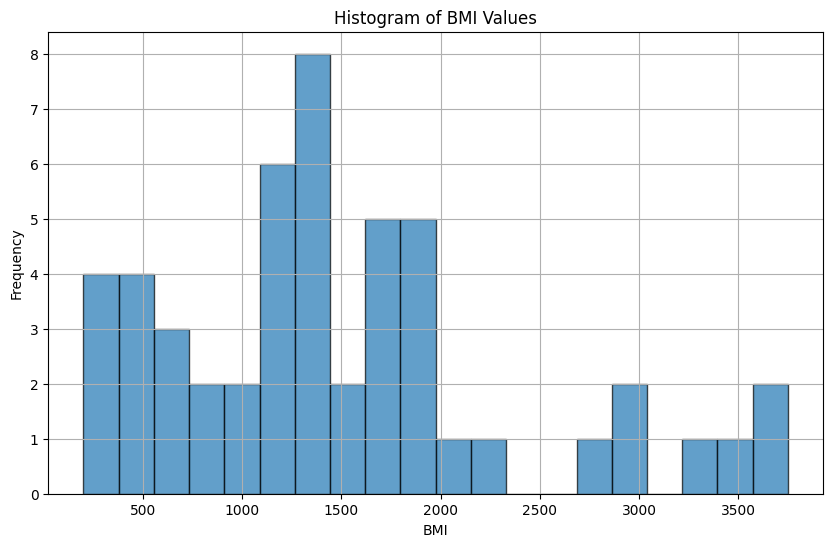

In [122]:
plt.figure(figsize=(10, 6))
plt.hist(pokemons_df['bmi'], bins=20, edgecolor='black', alpha=0.7)
plt.title('Histogram of BMI Values')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

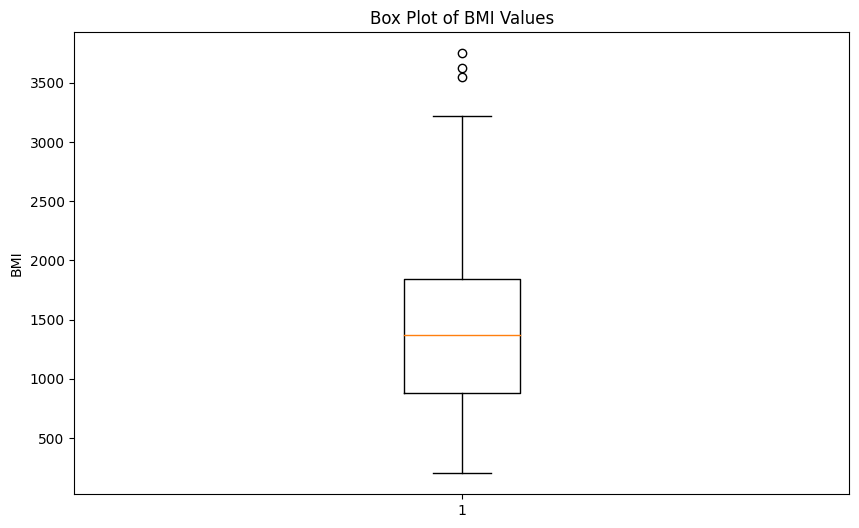

In [124]:
plt.figure(figsize=(10, 6))
plt.boxplot(pokemons_df['bmi'])
plt.title('Box Plot of BMI Values')
plt.ylabel('BMI')
plt.show()